In [ ]:
#-----------------------------------------------------------------------------------
#default module
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import pandas as pd
import os
import math
import torch
import torch.nn as nn
sns.set()
sns.set_style("ticks")

#-----------------------------------------------------------------------------------
#japanese
#import matplotlib
#matplotlib.rc('font', family='Hiragino Sans')

#for paper
#https://qiita.com/MENDY/items/fe9b0c50383d8b2fd919
plt.rcParams['font.family'] = 'Arial' # font familyの設定
#plt.rcParams['mathtext.fontset'] = 'stix' # math fontの設定a

#-----------------------------------------------------------------------------------
#pandas setting
#pd.set_option('display.max_columns', 50) #最大表示列数の指定
#pd.set_option('display.max_rows', 50) #最大表示行数の指定

#-----------------------------------------------------------------------------------
#original module
import sys
sys.path.append("G:\マイドライブ\python_functions") #win
sys.path.append("/Users/daikitatematsu/Library/CloudStorage/GoogleDrive-dikt1231@gmail.com/マイドライブ/python_functions") #mac
sys.path.append("/home/tatematsudaiki/GoogleDrive/python_functions/") #ubuntu
#import
import functions_processing
import functions_time
import functions_analyze_TS
import functions_statistics
import functions_ML
import functions_plot
import functions_plot_advance
import functions_torch

#-----------------------------------------------------------------------------------
sys.path.append("G:\マイドライブ\python_functions\func_ML") #win
sys.path.append("/Users/daikitatematsu/Library/CloudStorage/GoogleDrive-dikt1231@gmail.com/マイドライブ/python_functions/func_ML") #mac
sys.path.append("/home/tatematsudaiki/GoogleDrive/python_functions/func_ML") #ubuntu
#import
import func_innerCV
import func_smote
import func_accuracy_clf
import func_accuracy_reg
import func_FeatureImportance
import func_FeatureSelection
import func_FeatureEngineering
import func_FeatureEngineering_TS

---

# VAE

https://qiita.com/gensal/items/613d04b5ff50b6413aa0

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST, FashionMNIST
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import animation, rc

In [ ]:
#----------------------------
#var
BATCH_SIZE = 100

#----------------------------
#data
trainval_data = MNIST("./data", 
                   train=True, 
                   download=True, 
                   transform=transforms.ToTensor())

#----------------------------
#split data to train val
train_size = int(len(trainval_data) * 0.8)
val_size = int(len(trainval_data) * 0.2)
train_data, val_data = torch.utils.data.random_split(trainval_data, [train_size, val_size])

#----------------------------
#DataLoader (=dataをiterで取り出せる)
train_loader = DataLoader(dataset=train_data,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          num_workers=0)

val_loader = DataLoader(dataset=val_data,
                        batch_size=BATCH_SIZE,
                        shuffle=True,
                        num_workers=0)

print("train data size: ",len(train_data))   #train data size:  48000
print("train iteration number: ",len(train_data)//BATCH_SIZE)   #train iteration number:  480
print("val data size: ",len(val_data))   #val data size:  12000
print("val iteration number: ",len(val_data)//BATCH_SIZE)   #val iteration number:  120

images_size: torch.Size([100, 1, 28, 28])
label: tensor([9, 6, 7, 3, 3, 1, 0, 9, 3, 1])


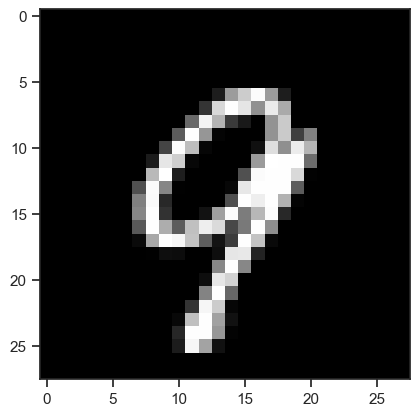

In [6]:
#----------------------------
#1つ取り出して可視化
images, labels = next(iter(train_loader))
print("images_size:",images.size())   #images_size: torch.Size([100, 1, 28, 28]) # 100枚の1チャネルの28×28の写真
print("label:",labels[:10])   #label: tensor([7, 6, 0, 6, 4, 8, 5, 2, 2, 3])

image_numpy = images.detach().numpy().copy()
plt.imshow(image_numpy[0,0,:,:], cmap='gray')

In [7]:
#----------------------------
#Encoder
class Encoder(nn.Module):
  def __init__(self, z_dim):
    super().__init__()
    self.lr = nn.Linear(28*28, 300) # 28*28 -> 300
    self.lr2 = nn.Linear(300, 100) # 300 -> 100
    self.lr_ave = nn.Linear(100, z_dim)   # 100 -> z_dim : average
    self.lr_dev = nn.Linear(100, z_dim)   # 100 -> z_dim : dev : log(sigma^2)
    self.relu = nn.ReLU()
  
  def forward(self, x): #fp
    x = self.lr(x)
    x = self.relu(x)
    x = self.lr2(x)
    x = self.relu(x)
    ave = self.lr_ave(x)    #average
    log_dev = self.lr_dev(x)    #log(sigma^2)

    ep = torch.randn_like(ave)   #平均0分散1の正規分布に従い生成されるz_dim次元の乱数
    z = ave + torch.exp(log_dev / 2) * ep   #再パラメータ化トリック
    return z, ave, log_dev

#----------------------------
#Decoder
class Decoder(nn.Module):
  def __init__(self, z_dim):
    super().__init__()
    self.lr = nn.Linear(z_dim, 100)
    self.lr2 = nn.Linear(100, 300)
    self.lr3 = nn.Linear(300, 28*28)
    self.relu = nn.ReLU()
  
  def forward(self, z):
    x = self.lr(z)
    x = self.relu(x)
    x = self.lr2(x)
    x = self.relu(x)
    x = self.lr3(x)
    x = torch.sigmoid(x)   #MNISTのピクセル値の分布はベルヌーイ分布に近いと考えられるので、シグモイド関数を適用します。
    return x

#----------------------------
#VAE (=Encoder + Decoder)
class VAE(nn.Module):
  def __init__(self, z_dim):
    super().__init__()
    self.encoder = Encoder(z_dim)
    self.decoder = Decoder(z_dim)
  
  def forward(self, x):
    z, ave, log_dev = self.encoder(x)
    x = self.decoder(z)
    return x, z, ave, log_dev


In [8]:
#----------------------------
#損失関数
def criterion(predict, target, ave, log_dev):
  bce_loss = F.binary_cross_entropy(predict, target, reduction='sum')
  kl_loss = -0.5 * torch.sum(1 + log_dev - ave**2 - log_dev.exp())
  loss = bce_loss + kl_loss
  return loss


In [9]:
#----------------------------
#var
z_dim = 2
num_epochs = 20

#----------------------------
#var for model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
model = VAE(z_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[15], gamma=0.1)

#----------------------------
#results
history = {"train_loss": [], "val_loss": [], "ave": [], "log_dev": [], "z": [], "labels":[]}

#----------------------------
#学習
for epoch in range(num_epochs):
  model.train()
  for i, (x, labels) in enumerate(train_loader):
    input = x.to(device).view(-1, 28*28).to(torch.float32)
    output, z, ave, log_dev = model(input)

    history["ave"].append(ave)
    history["log_dev"].append(log_dev)
    history["z"].append(z)
    history["labels"].append(labels)
    loss = criterion(output, input, ave, log_dev)
     
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
     
    if (i+1) % 50 == 0:
      print(f'Epoch: {epoch+1}, loss: {loss: 0.4f}')
    history["train_loss"].append(loss)

  model.eval()
  with torch.no_grad():
    for i, (x, labels) in enumerate(val_loader):
      input = x.to(device).view(-1, 28*28).to(torch.float32)
      output, z, ave, log_dev = model(input)

      loss = criterion(output, input, ave, log_dev)
      history["val_loss"].append(loss)
      
    print(f'Epoch: {epoch+1}, val_loss: {loss: 0.4f}')
  
  scheduler.step()

Epoch: 1, loss:  20919.4961
Epoch: 1, loss:  19638.7852
Epoch: 1, loss:  18495.3594
Epoch: 1, loss:  18181.1758
Epoch: 1, loss:  17677.8027
Epoch: 1, loss:  16935.3652
Epoch: 1, loss:  18015.9492
Epoch: 1, loss:  16823.9277
Epoch: 1, loss:  16914.0410
Epoch: 1, val_loss:  16067.1855
Epoch: 2, loss:  17197.9238
Epoch: 2, loss:  16765.5957
Epoch: 2, loss:  16342.4570
Epoch: 2, loss:  15664.1660
Epoch: 2, loss:  15873.1113
Epoch: 2, loss:  16269.0508
Epoch: 2, loss:  16182.7510
Epoch: 2, loss:  15359.5898
Epoch: 2, loss:  15679.2314
Epoch: 2, val_loss:  16379.3936
Epoch: 3, loss:  15816.6045
Epoch: 3, loss:  16051.5107
Epoch: 3, loss:  15961.9893
Epoch: 3, loss:  15687.7256
Epoch: 3, loss:  15636.1777
Epoch: 3, loss:  15981.6475
Epoch: 3, loss:  15254.9785
Epoch: 3, loss:  16075.4824
Epoch: 3, loss:  15209.5391
Epoch: 3, val_loss:  16030.6855
Epoch: 4, loss:  14846.2295
Epoch: 4, loss:  15178.1504
Epoch: 4, loss:  15027.6719
Epoch: 4, loss:  15491.4453
Epoch: 4, loss:  14711.8740
Epoch: 4

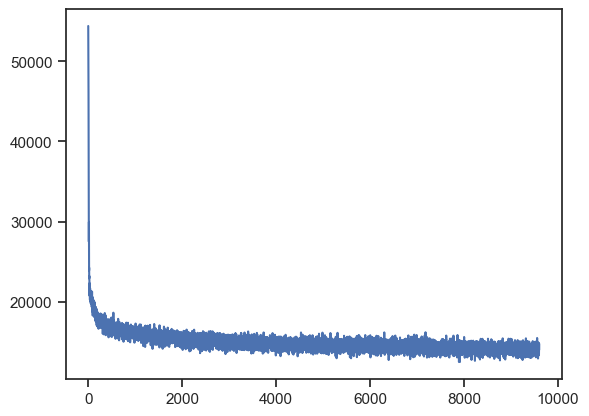

In [10]:
#----------------------------
#学習用データセットにおける損失の推移をプロット
train_loss_tensor = torch.stack(history["train_loss"])
train_loss_np = train_loss_tensor.to('cpu').detach().numpy().copy()
plt.plot(train_loss_np)

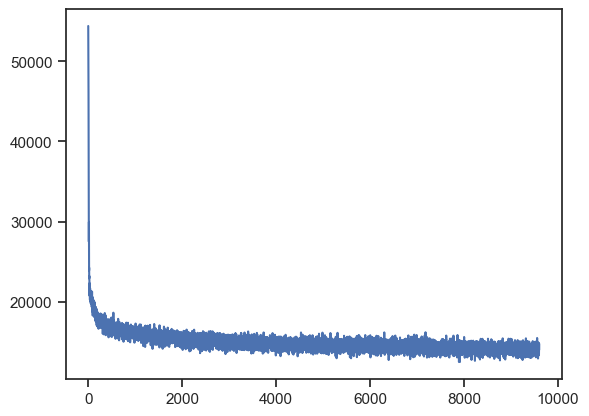

In [11]:
#----------------------------
#検証用データセットにおける損失の推移をプロット
train_loss_tensor = torch.stack(history["train_loss"])
train_loss_np = train_loss_tensor.to('cpu').detach().numpy().copy()
plt.plot(train_loss_np)

In [12]:
#----------------------------
#各学習パラメータの履歴を、numpy配列に変換します
ave_tensor = torch.stack(history["ave"])
log_var_tensor = torch.stack(history["log_dev"])
z_tensor = torch.stack(history["z"])
labels_tensor = torch.stack(history["labels"])
print(ave_tensor.size())   #torch.Size([9600, 100, 2])
print(log_var_tensor.size())   #torch.Size([9600, 100, 2])
print(z_tensor.size())   #torch.Size([9600, 100, 2])
print(labels_tensor.size())   #torch.Size([9600, 100])

#torch -> numpy配列
ave_np = ave_tensor.to('cpu').detach().numpy().copy()
log_var_np = log_var_tensor.to('cpu').detach().numpy().copy()
z_np = z_tensor.to('cpu').detach().numpy().copy()
labels_np = labels_tensor.to('cpu').detach().numpy().copy()
print(ave_np.shape)   #(9600, 100, 2)
print(log_var_np.shape)   #(9600, 100, 2)
print(z_np.shape)   #(9600, 100, 2)
print(labels_np.shape)   #(9600, 100)

torch.Size([9600, 100, 2])
torch.Size([9600, 100, 2])
torch.Size([9600, 100, 2])
torch.Size([9600, 100])
(9600, 100, 2)
(9600, 100, 2)
(9600, 100, 2)
(9600, 100)


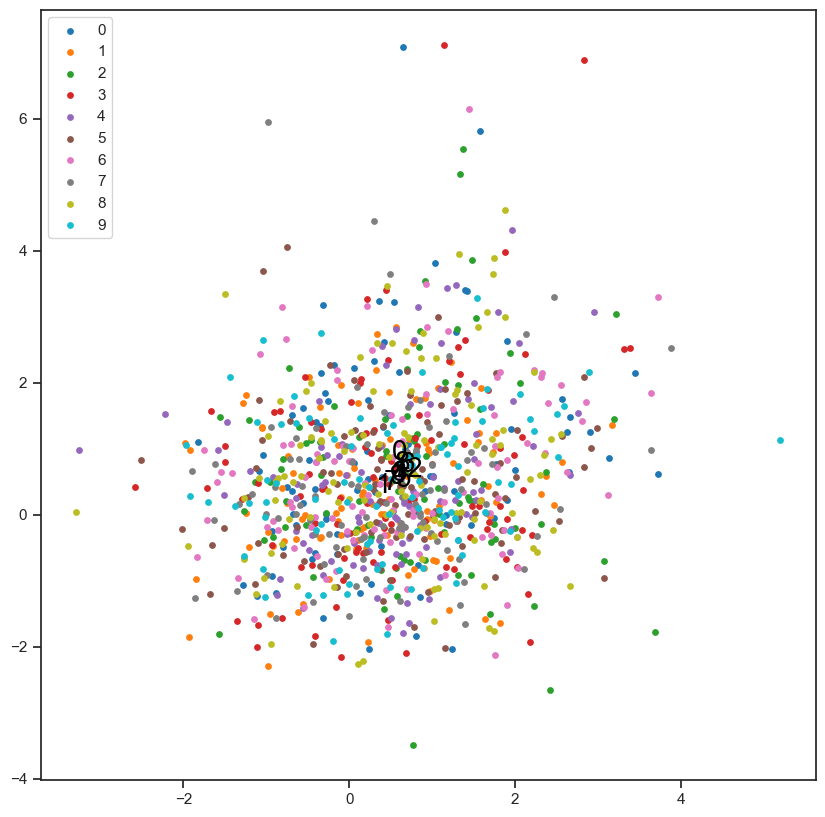

In [13]:
#----------------------------
#学習序盤の潜在変数の分布をプロット
cmap_keyword = "tab10"
cmap = plt.get_cmap(cmap_keyword)

batch_num =10
plt.figure(figsize=[10,10])
for label in range(10):
  x = z_np[:batch_num,:,0][labels_np[:batch_num,:] == label]
  y = z_np[:batch_num,:,1][labels_np[:batch_num,:] == label]
  plt.scatter(x, y, color=cmap(label/9), label=label, s=15)
  plt.annotate(label, xy=(np.mean(x),np.mean(y)),size=20,color="black")
plt.legend(loc="upper left")


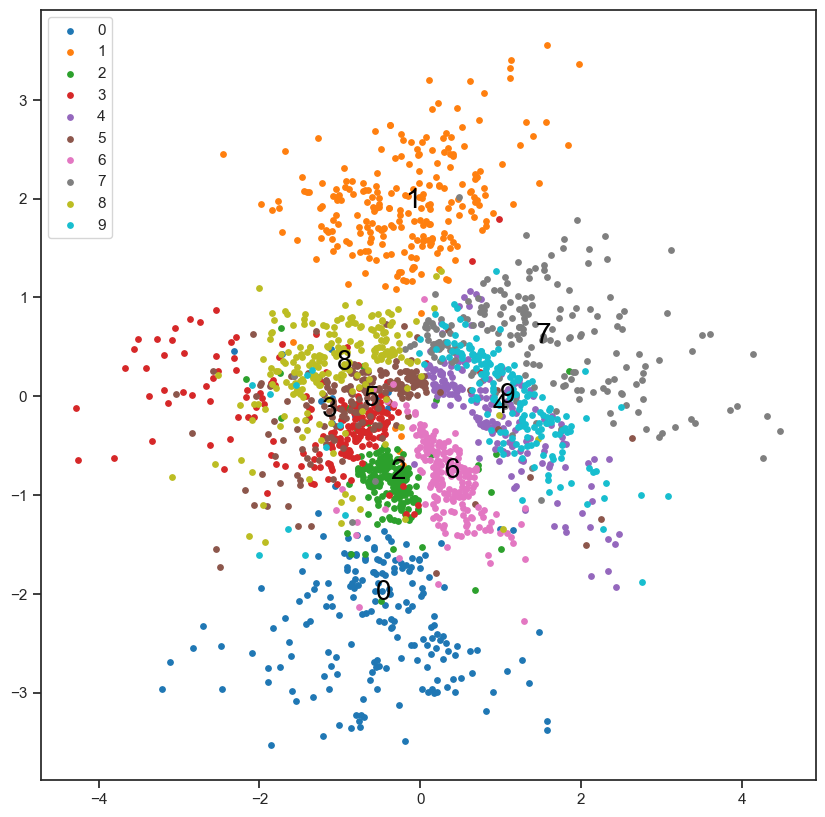

In [14]:
#----------------------------
#学習終盤の潜在変数の分布をプロット
batch_num = 9580
plt.figure(figsize=[10,10])
for label in range(10):
  x = z_np[batch_num:,:,0][labels_np[batch_num:,:] == label]
  y = z_np[batch_num:,:,1][labels_np[batch_num:,:] == label]
  plt.scatter(x, y, color=cmap(label/9), label=label, s=15)
  plt.annotate(label, xy=(np.mean(x),np.mean(y)),size=20,color="black")
plt.legend(loc="upper left")


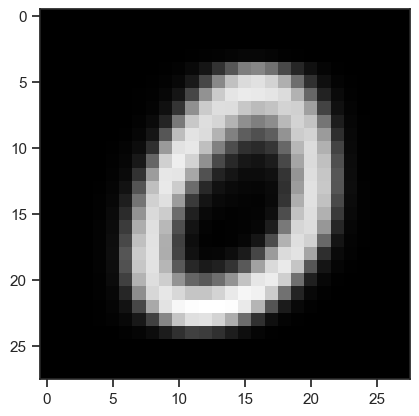

In [15]:
#----------------------------
#0の潜在変数の平均値をモデルのデコーダ部に流し込むことで、0の画像を生成します
model.to("cpu")

label = 0
x_zero_mean = np.mean(ave_np[batch_num:,:,0][labels_np[batch_num:,:] == label])   #x軸の平均値
y_zero_mean = np.mean(ave_np[batch_num:,:,1][labels_np[batch_num:,:] == label])   #y軸の平均値
z_zero = torch.tensor([x_zero_mean,y_zero_mean], dtype = torch.float32)

output = model.decoder(z_zero)
np_output = output.to('cpu').detach().numpy().copy()
np_image = np.reshape(np_output, (28, 28))
plt.imshow(np_image, cmap='gray')


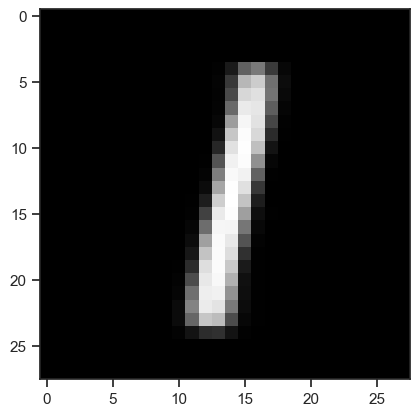

In [16]:
#----------------------------
#1の潜在変数の平均値をモデルのデコーダ部に流し込むことで、1の画像を生成します。
label = 1
x_one_mean = np.mean(ave_np[batch_num:,:,0][labels_np[batch_num:,:] == label])   #x軸の平均値
y_one_mean = np.mean(ave_np[batch_num:,:,1][labels_np[batch_num:,:] == label])   #y軸の平均値
z_one = torch.tensor([x_one_mean,y_one_mean], dtype = torch.float32)

output = model.decoder(z_one)
np_output = output.to('cpu').detach().numpy().copy()
np_image = np.reshape(np_output, (28, 28))
plt.imshow(np_image, cmap='gray')


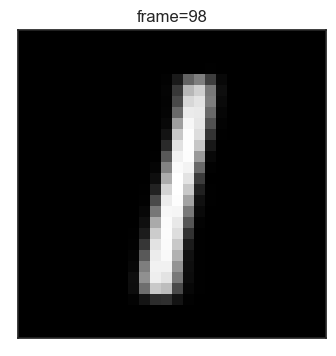

In [17]:
#----------------------------
#0から1まで潜在変数を移動する際のアニメーションを作成します
def plot(frame):
    plt.cla()
    z_zerotoone = ((99 - frame) * z_zero +  frame * z_one) / 99
    output = model.decoder(z_zerotoone)
    np_output = output.detach().numpy().copy()
    np_image = np.reshape(np_output, (28, 28))
    plt.imshow(np_image, cmap='gray')
    plt.xticks([]);plt.yticks([])
    plt.title("frame={}".format(frame))

fig = plt.figure(figsize=(4,4))
ani = animation.FuncAnimation(fig, plot, frames=99, interval=100)
rc('animation', html='jshtml')
ani
